In [1]:
import h5py
import netCDF4 as nc
import numpy as np
import pandas as pd
import os
from scipy.spatial import KDTree
from scipy.interpolate import griddata
pd.set_option('display.max.rows',10000)
from datetime import datetime,timedelta
from tqdm import tqdm
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from global_land_mask import globe

In [2]:
def read_ICESat2_h5(file_paths):
    
    # 初始化一个字典来存储每个beam的数据
    all_beams_data = {'gt1r': [], 'gt2r': [], 'gt3r': []}

    for file_path in file_paths:
        try:
            file_name = os.path.basename(file_path).split('_')[1]
            date_str = file_name[:8]
            date_obj = datetime.strptime(date_str, '%Y%m%d').date()

            with h5py.File(file_path, 'r') as h5_file:
                for beam in ['gt1r', 'gt2r', 'gt3r']:
                    lon = h5_file[f'{beam}/ssh_segments/longitude'][:]
                    lat = h5_file[f'{beam}/ssh_segments/latitude'][:]
                    h = h5_file[f'{beam}/ssh_segments/heights/h'][:]

                    data = {
                        'Longitude': lon,
                        'Latitude': lat,
                        'SSH': h,
                        'Date': [date_obj] * len(lon)
                    }
                    df = pd.DataFrame(data)

                    # 过滤数据
                    df = df[(df['Longitude'] >= 100) & (df['Longitude'] <= 140) &
                            (df['Latitude'] >= 0) & (df['Latitude'] <= 50)]

                    all_beams_data[beam].append(df)
        except Exception as e:
            print(f"Error reading file {file_path}: {e}")

    # 合并每个beam的DataFrame列表
    for beam in all_beams_data:
        all_beams_data[beam] = pd.concat(all_beams_data[beam], ignore_index=True)

    return all_beams_data


In [10]:
def get_file_paths(directory):
     return [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith('.h5')]

In [11]:
directory_path = r'F:\nasa\is2\atl12'
file_paths = get_file_paths(directory_path)
beams_data = read_ICESat2_h5(file_paths)

df_gt1r = beams_data['gt1r']
df_gt2r = beams_data['gt2r']
df_gt3r = beams_data['gt3r']

Error reading file F:\nasa\is2\atl12\ATL12_20181127154919_09170101_006_04.h5: Unable to open file (truncated file: eof = 383992023, sblock->base_addr = 0, stored_eof = 511772740)
Error reading file F:\nasa\is2\atl12\ATL12_20190106221735_01450201_006_02.h5: Unable to open file (truncated file: eof = 311427072, sblock->base_addr = 0, stored_eof = 627075439)
Error reading file F:\nasa\is2\atl12\ATL12_20190626151041_13650301_006_02.h5: 'Unable to open object (component not found)'
Error reading file F:\nasa\is2\atl12\ATL12_20190830123149_09690401_006_02.h5: Unable to open file (truncated file: eof = 249640023, sblock->base_addr = 0, stored_eof = 465723587)
Error reading file F:\nasa\is2\atl12\ATL12_20200917180341_12890801_006_02.h5: Unable to open file (truncated file: eof = 123944023, sblock->base_addr = 0, stored_eof = 336714941)
Error reading file F:\nasa\is2\atl12\ATL12_20201203035947_10690901_006_01.h5: Unable to open file (truncated file: eof = 226304023, sblock->base_addr = 0, store

In [2]:
df_gt1r = pd.read_csv(r"F:\nasa\is2\atl12\beams\gt1r_ssha.csv")
df_gt3r = pd.read_csv(r"F:\nasa\is2\atl12\beams\gt3r_ssha.csv")
df_gt2r = pd.read_csv(r"F:\nasa\is2\atl12\beams\gt2r_ssha.csv")



In [51]:
#比较三条beam 的ssha

In [3]:
#读取mss
from netCDF4 import Dataset
import numpy as np
import xarray as xr

# 文件路径
mss_file = r"F:\DTU21MSS_1min.mss.nc"

# 读取 DTU21 MSS 数据
with Dataset(mss_file, 'r') as nc:
    mss_lon = nc.variables['lon'][:]  # 根据实际变量名调整
    mss_lat = nc.variables['lat'][:]  # 根据实际变量名调整
    mss_data = nc.variables['mss'][:]  # 根据实际变量名调整

In [4]:
from scipy.interpolate import RegularGridInterpolator

# 创建两个插值器，一个用于 'linear'，另一个用于 'nearest'
linear_interpolator = RegularGridInterpolator((mss_lat, mss_lon), mss_data, method='linear', bounds_error=False, fill_value=np.nan)
nearest_interpolator = RegularGridInterpolator((mss_lat, mss_lon), mss_data, method='nearest', bounds_error=False, fill_value=np.nan)

def combined_interpolation(icesat2_df):
    # 先用 'linear' 方法插值
    points = np.array(list(zip(icesat2_df['Latitude'], icesat2_df['Longitude'])))
    mss_values_linear = linear_interpolator(points)
    
    # 检查是否有 NaN，并用 'nearest' 方法填充这些 NaN
    mask_nan = np.isnan(mss_values_linear)
    mss_values_nearest = nearest_interpolator(points[mask_nan])
    
    # 将 'nearest' 插值的结果放回原来的数组中
    mss_values_linear[mask_nan] = mss_values_nearest

    return mss_values_linear




In [5]:
#计算三条beam的ssha
def apply_interpolation_and_compute_ssha(df):
    # 应用组合插值来计算 MSS
    df['MSS'] = combined_interpolation(df)
    # 计算 SSHA
    df['SSHA'] = df['SSH'] - df['MSS']
    return df

In [6]:
#每条beam 月平均
df_gt1r = apply_interpolation_and_compute_ssha(df_gt1r)
df_gt2r = apply_interpolation_and_compute_ssha(df_gt2r)
df_gt3r = apply_interpolation_and_compute_ssha(df_gt3r)

In [7]:
# 计算每条 beam 的每月平均 SSHA
df_gt1r['Date'] = pd.to_datetime(df_gt1r['Date'])
df_gt2r['Date'] = pd.to_datetime(df_gt2r['Date'])
df_gt3r['Date'] = pd.to_datetime(df_gt3r['Date'])

monthly_avg_ssha_gt1r = df_gt1r.resample('M', on='Date').mean()['SSHA']
monthly_avg_ssha_gt2r = df_gt2r.resample('M', on='Date').mean()['SSHA']
monthly_avg_ssha_gt3r = df_gt3r.resample('M', on='Date').mean()['SSHA']#标注为最后一天

In [10]:
monthly_avg_ssha_gt1r.index = monthly_avg_ssha_gt1r.index.to_period('M').to_timestamp('M') + pd.offsets.MonthBegin(n=0)#标注为第一天
monthly_avg_ssha_gt2r.index = monthly_avg_ssha_gt2r.index.to_period('M').to_timestamp('M')+ pd.offsets.MonthBegin(n=0)
monthly_avg_ssha_gt3r.index = monthly_avg_ssha_gt3r.index.to_period('M').to_timestamp('M')+ pd.offsets.MonthBegin(n=0)

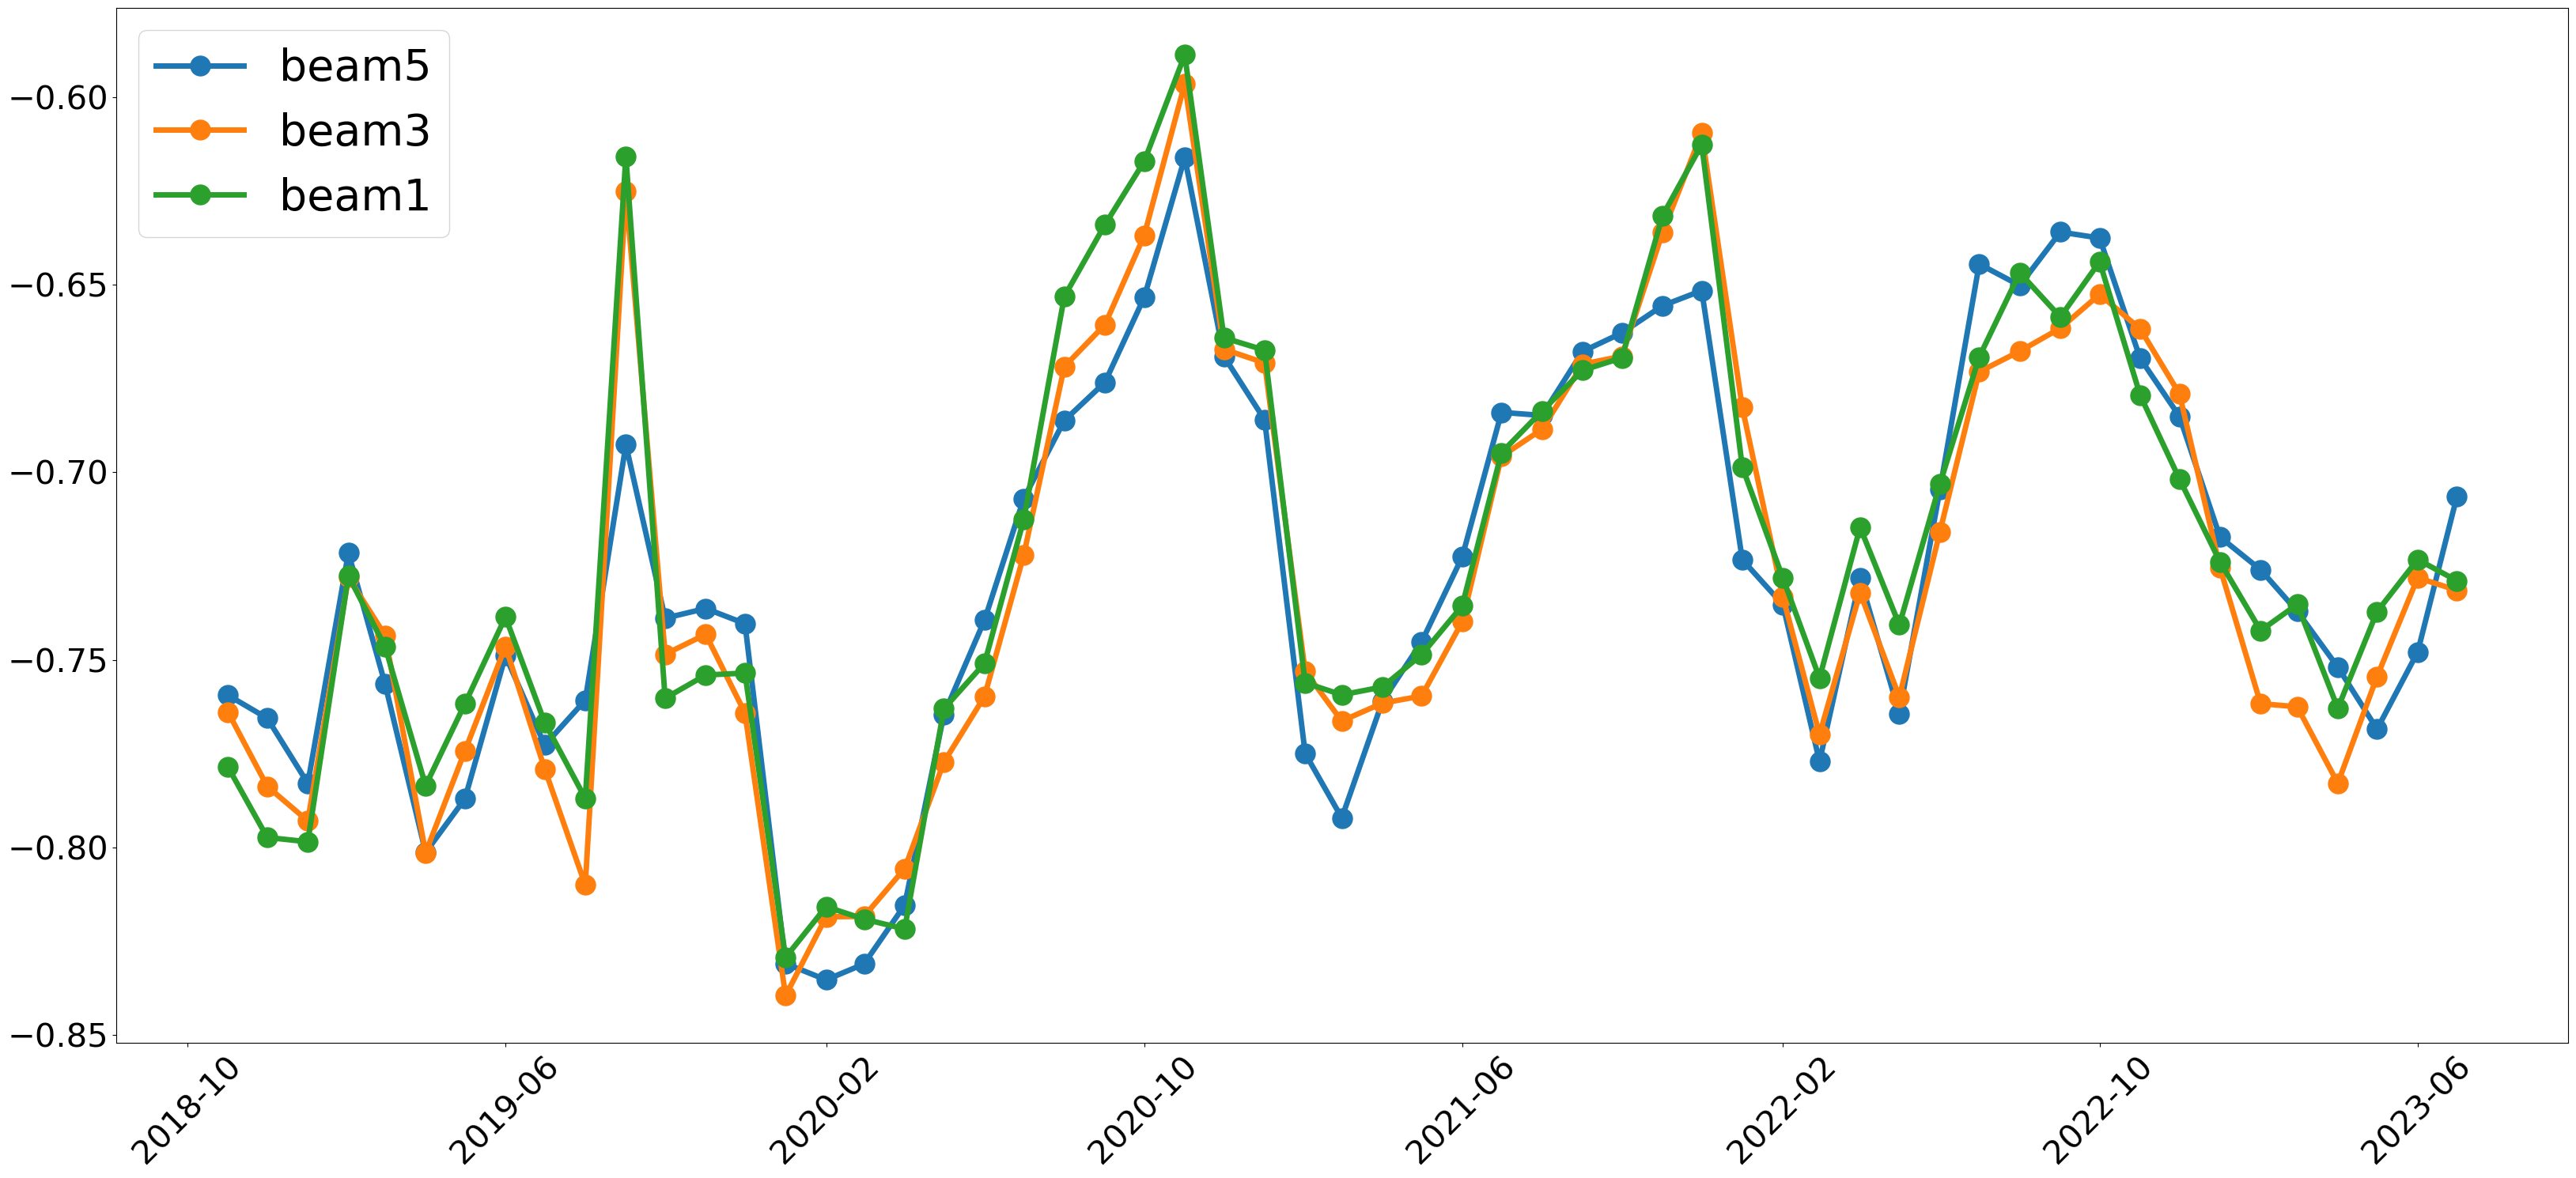

In [10]:
import matplotlib.dates as mdates
plt.figure(figsize=(40, 17))


plt.plot(monthly_avg_ssha_gt1r.index, monthly_avg_ssha_gt1r, marker='o', markersize=18, label='beam5', linewidth=5)
plt.plot(monthly_avg_ssha_gt2r.index, monthly_avg_ssha_gt2r, marker='o', markersize=18, label='beam3', linewidth=5)
plt.plot(monthly_avg_ssha_gt3r.index, monthly_avg_ssha_gt3r, marker='o', markersize=18, label='beam1', linewidth=5)


plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# 设置自定义的日期刻度
custom_ticks = pd.to_datetime(['2018-10', '2019-06', '2020-02', '2020-10', '2021-06', '2022-02', '2022-10', '2023-06'])
plt.gca().set_xticks(custom_ticks)


# plt.xlabel('Date', fontsize=35)
# plt.ylabel('Monthly Average SSHA (m)', fontsize=35)
# plt.title('Monthly Average SSHA Time Series for Beam1,Beam3,Beam5', fontsize=50)
plt.legend(fontsize=40,loc = 2)


plt.xticks(rotation=45, fontsize=30)
plt.yticks(fontsize=30)



plt.savefig(r'D:\BF\Desktop\monthly_avg_ssha_comparison.png', dpi=400, bbox_inches='tight')


plt.show()

In [12]:
monthly_avg_ssha_gt1r.to_csv(r'F:\nasa\is2\atl12\beams\monthly_avg_ssha_gt1r.csv')
monthly_avg_ssha_gt2r.to_csv(r'F:\nasa\is2\atl12\beams\monthly_avg_ssha_gt2r.csv')
monthly_avg_ssha_gt3r.to_csv(r'F:\nasa\is2\atl12\beams\monthly_avg_ssha_gt3r.csv')

In [15]:
#计算相关系数

monthly_avg_ssha = pd.DataFrame({
    'gt1r': monthly_avg_ssha_gt1r,
    'gt2r': monthly_avg_ssha_gt2r,
    'gt3r': monthly_avg_ssha_gt3r
})


correlation_matrix = monthly_avg_ssha.corr()


correlation_matrix


,gt1r,gt2r,gt3r
gt1r,1.000000,0.935604,0.931646
gt2r,0.935604,1.000000,0.980162
gt3r,0.931646,0.980162,1.000000


In [11]:
df_gt2r['Date'] = pd.to_datetime(df_gt2r['Date'])
df_gt1r['Date'] = pd.to_datetime(df_gt1r['Date'])
df_gt3r['Date'] = pd.to_datetime(df_gt3r['Date'])


In [8]:
#总的
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from global_land_mask import globe

def interpolate_ssha(df, grid_lon, grid_lat):
    # 首先尝试'linear'插值
    ssha_values = griddata((df['Longitude'], df['Latitude']), df['SSHA'], (grid_lon, grid_lat), method='linear')
    
    # 检查是否有NaN值，如果有，则使用'nearest'填充这些值
    if np.isnan(ssha_values).any():
        ssha_values_nearest = griddata((df['Longitude'], df['Latitude']), df['SSHA'], (grid_lon, grid_lat), method='nearest')
        # 使用np.isnan找到ssha_values中的NaN值，然后用'nearest'的结果填充
        ssha_values[np.isnan(ssha_values)] = ssha_values_nearest[np.isnan(ssha_values)]
    
    return ssha_values

In [9]:
grid_res = 0.5  # 这里可以根据需要调整分辨率


lon_min, lon_max, lat_min, lat_max = 100, 140, 0, 50


grid_lon, grid_lat = np.mgrid[lon_min:lon_max:grid_res, lat_min:lat_max:grid_res]

# 创建一个与grid_lon和grid_lat形状相同的掩码数组
is_land_mask = np.zeros(grid_lon.shape, dtype=bool)

# 为每个格网点填充掩码
for i in range(grid_lon.shape[0]):
    for j in range(grid_lon.shape[1]):
        is_land_mask[i, j] = globe.is_land(grid_lat[i, j], grid_lon[i, j])

# 插值计算每个格网点的SSHA

grid_ssha_gt1r = interpolate_ssha(df_gt1r, grid_lon, grid_lat)
grid_ssha_gt2r = interpolate_ssha(df_gt2r, grid_lon, grid_lat)
grid_ssha_gt3r = interpolate_ssha(df_gt3r, grid_lon, grid_lat)

# 计算SSHA差异
diff_ssha_beam5_beam3 = grid_ssha_gt1r - grid_ssha_gt2r  # Beam 5 - Beam 3
diff_ssha_beam5_beam1 = grid_ssha_gt1r - grid_ssha_gt3r  # Beam 5 - Beam 1
diff_ssha_beam3_beam1 = grid_ssha_gt2r - grid_ssha_gt3r  # Beam 3 - Beam 1

all_data = np.concatenate([diff_ssha_beam5_beam3.ravel(),
                           diff_ssha_beam5_beam1.ravel(),
                           diff_ssha_beam3_beam1.ravel()])
vmin, vmax = np.percentile(all_data, [15, 85])

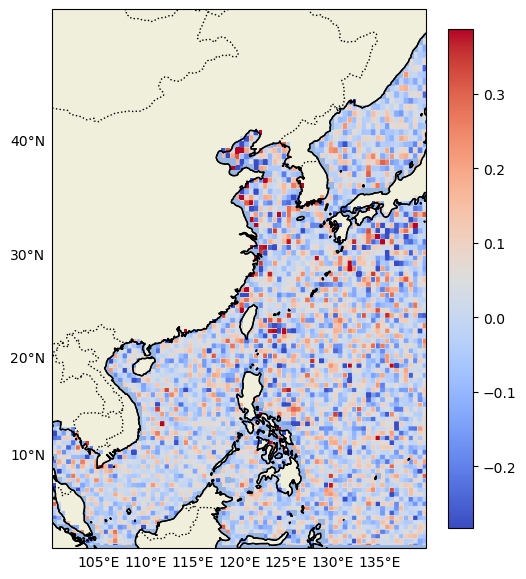

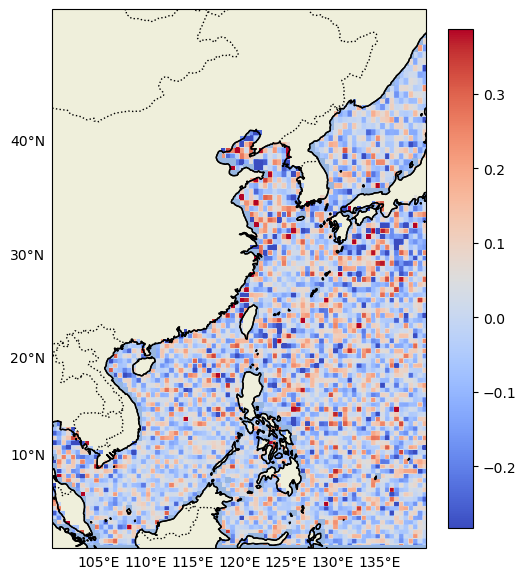

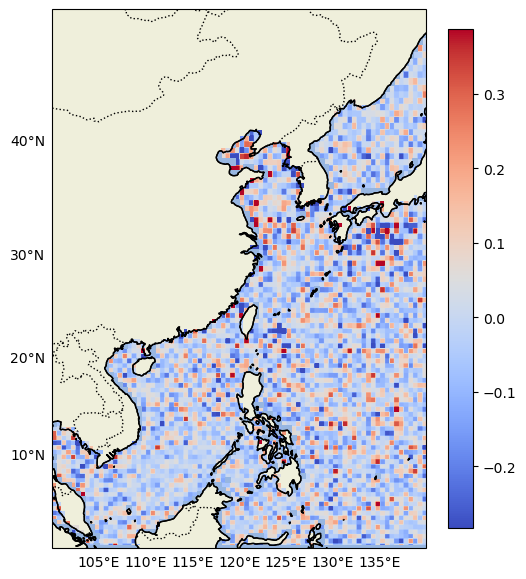

In [11]:
from cartopy import crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import matplotlib.pyplot as plt
extent = [lon_min, lon_max, lat_min, lat_max]




# 设置墨卡托投影
projection = ccrs.Mercator()

# 绘制每个差异图
titles = ['Beam 5 - Beam 3', 'Beam 5 - Beam 1', 'Beam 3 - Beam 1']
diffs = [diff_ssha_beam5_beam3, diff_ssha_beam5_beam1, diff_ssha_beam3_beam1]

for i, (diff, title) in enumerate(zip(diffs, titles)):
    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={'projection': projection})
    
    # 添加格网线及其标签
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0, color='none', alpha=0, linestyle='')
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    ax.set_extent(extent, crs=ccrs.PlateCarree())
#     ax.set_title(f'{title} SSHA Difference')
    ax.coastlines()
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    
    # 掩盖陆地的SSHA值
    masked_diff = np.ma.array(diff, mask=is_land_mask)
    
    # 绘制差异数据图
    img_extent = (lon_min, lon_max, lat_min, lat_max)
    pcm = ax.imshow(masked_diff.T, extent=img_extent, origin='lower',
                    transform=ccrs.PlateCarree(), cmap='coolwarm', vmin=vmin, vmax=vmax)
    
    # 在图的右侧添加一个颜色条
    cbar = fig.colorbar(pcm, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
#     cbar.set_label('SSHA Difference (m)')
    
    # 保存图像
    plt.savefig(f'D:\\BF\\Desktop\\icesat-2_beam_{i+1}.png', dpi=400, bbox_inches='tight')
    plt.show()


In [11]:
import numpy as np
import matplotlib.pyplot as plt

titles = ['Beam 5 - Beam 3', 'Beam 5 - Beam 1', 'Beam 3 - Beam 1']
differences = [diff_ssha_beam5_beam3, diff_ssha_beam5_beam1, diff_ssha_beam3_beam1]
bins = np.linspace(-0.2, 0.2, 10)

# 为每个数据集绘制并保存直方图
for i, (diff, title) in enumerate(zip(differences, titles)):
    fig, ax = plt.subplots(figsize=(7, 7))
    
    # 计算直方图的值
    counts, edges = np.histogram(diff, bins=bins)
    
    # 绘制直方图
    ax.bar(edges[:-1], counts, width=np.diff(edges), edgecolor='black', color='#87CEFA', align='edge')
    
    # 计算并显示均值和标准差
    mean = diff.mean()
    std = diff.std()
    ax.axvline(mean, color='black', linestyle='dashed', linewidth=2)
    
    # 移除上边界和右边界
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # 更新图表标题和轴标签
#     ax.set_title(title)
#     ax.set_xlabel('SSHA Difference (m)')
#     ax.set_ylabel('Grid cell count')
    
    plt.tight_layout()
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    # 保存每个子图为单独的文件
    plt.savefig(f'D:\\BF\\Desktop\\icesat-2_beam_{i+1}.png', dpi=400, bbox_inches='tight')
    plt.close()


In [13]:

diff_ssha_beam3_beam1.mean()


-0.07148706863176446

In [2]:
monthly_avg_ssha_gt1r = pd.read_csv(r"F:\nasa\is2\atl12\beams\monthly_avg_ssha_gt1r.csv")
monthly_avg_ssha_gt2r = pd.read_csv(r"F:\nasa\is2\atl12\beams\monthly_avg_ssha_gt2r.csv")
monthly_avg_ssha_gt3r = pd.read_csv(r"F:\nasa\is2\atl12\beams\monthly_avg_ssha_gt3r.csv")
monthly_avg_ssha_gt2r

,Date,SSHA
0,2018/11/1,-0.763938
1,2018/12/1,-0.783744
2,2019/1/1,-0.792953
3,2019/2/1,-0.728025
4,2019/3/1,-0.743446
5,2019/4/1,-0.801438
6,2019/5/1,-0.774319
7,2019/6/1,-0.746422
8,2019/7/1,-0.779098
9,2019/8/1,-0.810055


In [6]:
#read_nc

def read_S3A_nc(file_path):
    file_name = file_path.split('\\')[-1]  # 假设使用反斜杠分隔的Windows文件路径
    date_str = file_name[16:23]  
    date_obj = datetime.strptime(date_str, '%Y%m%d').date()
    # 打开 NetCDF 文件
    with nc.Dataset(file_path, 'r') as nc_file:
        # 读取数据
        lon = nc_file.variables['lon_20_ku'][:]
        lat = nc_file.variables['lat_20_ku'][:]
        mss = nc_file.variables['mean_sea_surf_sol2_20_ku'][:]                                           #ssh用哪个
        lon[lon > 180] -= 360
        # 创建 DataFrame
        data = {
            'Longitude': lon,
            'Latitude': lat,
            'SSH': ssh,
            'Date': [date_obj] * len(lon)
        }
        s3a_data = pd.DataFrame(data)
        

    return s3a_data

In [35]:
grid_ssha_gt1r_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.299247,-0.299247,-1.113362,-1.113362,-1.113362,-0.722724,-0.976909,-0.942914,-0.926964,-0.664158,...,1.443546,1.443546,1.443546,1.443546,1.443546,1.443546,1.443546,1.443546,1.443546,1.443546
1,-1.130986,-0.299247,-0.299247,-0.862786,-0.862786,-0.739956,-0.679723,-0.718406,-0.554573,-0.877049,...,1.443546,1.443546,1.443546,1.443546,1.443546,1.443546,1.443546,1.443546,1.443546,1.443546
2,-1.693113,-1.130986,-0.299247,-0.299247,-0.532553,-0.882664,-0.679459,-0.995533,-0.987333,-0.945775,...,1.443546,1.443546,1.443546,1.443546,1.443546,1.443546,1.443546,1.443546,1.443546,1.443546
3,-1.693113,-1.693113,0.346986,0.346986,-0.738060,-0.565816,-0.234800,-0.953719,-0.974732,-0.933174,...,1.443546,1.443546,1.443546,1.443546,1.443546,1.443546,1.443546,1.443546,1.443546,1.443546
4,-1.693113,-1.693113,-1.693113,-0.873239,-0.929039,-1.102124,-0.768783,-0.927602,-0.982675,-0.920574,...,1.443546,1.443546,1.443546,1.443546,1.443546,1.443546,1.443546,1.443546,1.443546,1.443546
5,0.799611,-0.388829,-0.504855,-0.889009,-0.855096,-0.703551,-1.094762,-0.742796,-0.997092,-0.910487,...,1.443546,1.443546,1.443546,1.443546,1.443546,1.443546,1.443546,1.443546,1.443546,1.443546
6,-1.048652,0.799611,-1.284308,-1.002893,-1.095660,-0.792462,-0.901952,-1.000640,-0.950735,-0.924903,...,1.443546,1.443546,1.443546,1.443546,1.443546,1.443546,1.443546,1.443546,1.443546,1.443546
7,-0.979708,-0.762635,-0.961558,-0.272468,-0.935922,-0.925846,-0.714944,-0.895575,-0.655417,-0.822931,...,1.443546,1.443546,1.443546,1.443546,1.443546,1.443546,1.443546,1.443546,1.443546,1.443546
8,-0.771217,-0.889874,-0.572911,0.345853,-0.067471,-0.730138,-0.737684,-0.724675,-0.744562,-0.777904,...,1.443546,1.443546,1.443546,1.443546,1.443546,1.443546,1.443546,1.443546,1.443546,1.443546
9,-0.297624,-0.719568,-0.739452,-0.799501,-0.559816,-0.704481,-0.599182,-0.692241,-0.838450,-0.768120,...,1.443546,1.443546,1.443546,1.443546,1.443546,1.443546,1.443546,1.443546,1.443546,1.443546


In [34]:
grid_ssha_gt2r_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.356527,0.356527,-0.808598,-0.808598,-0.808598,-0.779076,-0.762993,-0.901586,-0.898299,-0.956486,...,0.263790,0.263790,0.263790,0.263790,0.263790,0.263790,0.263790,0.263790,0.263790,0.263790
1,-0.309333,0.356527,0.356527,-0.808598,-0.808598,-0.737265,-0.558654,-0.811386,-0.498285,-0.878953,...,0.263790,0.263790,0.263790,0.263790,0.263790,0.263790,0.263790,0.263790,0.263790,0.263790
2,-1.649115,-0.309333,0.356527,0.356527,-0.722101,-0.873088,-0.737923,-0.923678,-1.062406,-1.374382,...,0.263790,0.263790,0.263790,0.263790,0.263790,0.263790,0.263790,0.263790,0.263790,0.263790
3,-1.649115,-1.649115,0.396503,0.396503,-0.678253,-0.731299,-0.818378,-0.897646,-0.863423,-1.159525,...,0.263790,0.263790,0.263790,0.263790,0.263790,0.263790,0.263790,0.263790,0.263790,0.263790
4,-1.649115,-1.649115,-1.649115,-1.034983,-0.797234,-1.112654,-0.769153,-0.848552,-0.831555,-0.944669,...,0.263790,0.263790,0.263790,0.263790,0.263790,0.263790,0.263790,0.263790,0.263790,0.263790
5,0.790560,0.762135,-1.216244,-0.952807,-0.728348,-0.729752,-0.206422,-0.824418,-0.801204,-0.788037,...,0.263790,0.263790,0.263790,0.263790,0.263790,0.263790,0.263790,0.263790,0.263790,0.263790
6,0.790560,0.758812,-0.740892,-1.253190,-1.175620,-0.778226,-0.552693,-0.775193,-0.788794,-0.756170,...,0.263790,0.263790,0.263790,0.263790,0.263790,0.263790,0.263790,0.263790,0.263790,0.263790
7,-0.847609,-0.474301,-0.993922,-0.096766,-0.789234,-0.856587,-0.933362,-0.897164,-0.796013,-0.819879,...,0.263790,0.263790,0.263790,0.263790,0.263790,0.263790,0.263790,0.263790,0.263790,0.263790
8,-0.783885,-0.779946,-0.735691,0.600203,-0.624750,-0.741194,-0.675635,-0.867790,-0.769682,-0.739058,...,0.263790,0.263790,0.263790,0.263790,0.263790,0.263790,0.263790,0.263790,0.263790,0.263790
9,-0.335521,-0.712570,-0.821617,-0.843329,-0.703069,-0.701886,-0.595411,-0.602907,-0.793865,-0.886965,...,0.263790,0.263790,0.263790,0.263790,0.263790,0.263790,0.263790,0.263790,0.263790,0.263790


In [36]:
grid_ssha_gt3r_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-1.073070,-1.073070,-1.010790,-1.010790,-1.010790,-0.679795,-0.985855,-0.689963,-0.958229,-0.870661,...,0.423973,0.423973,0.423973,0.423973,0.423973,0.423973,0.423973,0.423973,0.423973,0.423973
1,-1.073070,-1.073070,-1.073070,-1.010790,-1.010790,-0.864592,-0.503928,-0.662834,-0.818336,-0.871666,...,0.423973,0.423973,0.423973,0.423973,0.423973,0.423973,0.423973,0.423973,0.423973,0.423973
2,0.116840,-1.073070,-1.073070,-1.073070,-1.109629,-0.881379,-0.755380,-0.910653,-0.867348,-0.919333,...,0.423973,0.423973,0.423973,0.423973,0.423973,0.423973,0.423973,0.423973,0.423973,0.423973
3,0.116840,0.116840,0.249091,0.595403,-0.799534,-1.001684,-1.324986,-1.032675,-0.862037,-0.873629,...,0.423973,0.423973,0.423973,0.423973,0.423973,0.423973,0.423973,0.423973,0.423973,0.423973
4,-1.947655,0.116840,0.116840,-0.741465,-0.855509,-1.024894,-1.137640,-1.182982,-0.912434,-0.841262,...,0.423973,0.423973,0.423973,0.423973,0.423973,0.423973,0.423973,0.423973,0.423973,0.423973
5,-1.947655,-1.947655,-0.832018,-0.951359,-0.789488,-0.717104,-0.950294,-1.078251,-0.962475,-0.784990,...,0.423973,0.423973,0.423973,0.423973,0.423973,0.423973,0.423973,0.423973,0.423973,0.423973
6,-1.947655,-1.947655,-0.832535,-1.315414,-1.097713,-0.779373,-0.779190,-0.918367,-0.995727,-0.835387,...,0.423973,0.423973,0.423973,0.423973,0.423973,0.423973,0.423973,0.423973,0.423973,0.423973
7,-0.930352,-0.767108,-0.794242,-0.511681,-0.898902,-0.816478,-0.781769,-0.985320,-0.763158,-0.840410,...,0.423973,0.423973,0.423973,0.423973,0.423973,0.423973,0.423973,0.423973,0.423973,0.423973
8,-0.709476,-0.805541,-0.907943,-0.016849,-0.315109,-0.811843,-0.669182,-0.800404,-0.718291,-0.790751,...,0.423973,0.423973,0.423973,0.423973,0.423973,0.423973,0.423973,0.423973,0.423973,0.423973
9,-1.440082,-0.604811,-0.777032,-0.717852,-0.824559,-0.722314,-0.727320,-0.604333,-0.615829,-0.755108,...,0.423973,0.423973,0.423973,0.423973,0.423973,0.423973,0.423973,0.423973,0.423973,0.423973


In [37]:
corr_matrix_1_2 = grid_ssha_gt1r_df.corrwith(grid_ssha_gt2r_df)
corr_matrix_1_3 = grid_ssha_gt1r_df.corrwith(grid_ssha_gt3r_df)
corr_matrix_2_3 = grid_ssha_gt2r_df.corrwith(grid_ssha_gt3r_df)

In [38]:
correlation_matrix = np.eye(3)

# 将相关系数的平均值填充到矩阵中
correlation_matrix[0, 1] = corr_matrix_1_2.mean()
correlation_matrix[1, 0] = corr_matrix_1_2.mean()  
correlation_matrix[0, 2] = corr_matrix_1_3.mean()
correlation_matrix[2, 0] = corr_matrix_1_3.mean()  
correlation_matrix[1, 2] = corr_matrix_2_3.mean()
correlation_matrix[2, 1] = corr_matrix_2_3.mean()  

correlation_matrix

array([[1.        , 0.58531019, 0.59657463],
       [0.58531019, 1.        , 0.66917928],
       [0.59657463, 0.66917928, 1.        ]])

In [1]:
#DTU21插值到交叉点上

In [2]:
#读取DTU21 MSS数据

In [4]:
pd1 = pd.read_csv(r"F:\nasa\is2\atl12\beams\gt2r_ssha.csv")
pd1

,Unnamed: 0,Longitude,Latitude,SSH,Date,MSS,SSHA
0,0,138.502422,0.007555,71.387596,2018-10-14,72.136479,-0.748883
1,1,138.500893,0.022813,71.504170,2018-10-14,72.185855,-0.681682
2,2,138.499719,0.034543,71.526750,2018-10-14,72.224116,-0.697367
3,3,138.498193,0.049790,71.548170,2018-10-14,72.274422,-0.726250
4,4,138.497017,0.061525,71.602670,2018-10-14,72.312755,-0.710086
...,...,...,...,...,...,...,...
1138394,1138394,103.563480,6.604381,-4.628600,2023-06-21,-3.836282,-0.792318
1138395,1138395,103.557578,6.545553,-4.471357,2023-06-21,-3.682668,-0.788688
1138396,1138396,103.551575,6.485769,-4.301078,2023-06-21,-3.512742,-0.788336
1138397,1138397,103.545491,6.425159,-4.150082,2023-06-21,-3.335271,-0.814811


In [40]:
diff_ssha_beam5_beam1

array([[ 0.77382267,  0.77382267,  0.77382267, ...,  1.01957322,
         1.01957322,  1.01957322],
       [ 0.77382267,  0.77382267,  0.77382267, ...,  1.01957322,
         1.01957322,  1.01957322],
       [ 0.77382267,  0.77382267,  0.77382267, ...,  1.01957322,
         1.01957322,  1.01957322],
       ...,
       [-0.12690536,  0.04872962,  0.0075252 , ..., -0.1756515 ,
        -0.11189659, -0.11189659],
       [ 0.15621492,  0.17123633, -0.04081474, ..., -0.11189659,
        -0.11189659, -0.11189659],
       [-0.16807316, -0.01290311, -0.03977358, ..., -0.11189659,
        -0.11189659, -0.11189659]])

In [3]:
df = pd.read_csv(r"F:\nasa\is2\atl12\beams\df_gt2r.csv")
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'F:\\nasa\\is2\\atl12\\beams\\df_gt2r.csv'

In [16]:
df_gt2r = pd.read_csv(r"F:\nasa\is2\atl12\beams\gt2r_ssha.csv")

In [32]:
df = df_gt2r
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')


In [33]:
df

,Unnamed: 0,Longitude,Latitude,SSH,Date,MSS,SSHA
0,0,138.502422,0.007555,71.387596,2018-10-14,72.136479,-0.748883
1,1,138.500893,0.022813,71.504170,2018-10-14,72.185855,-0.681682
2,2,138.499719,0.034543,71.526750,2018-10-14,72.224116,-0.697367
3,3,138.498193,0.049790,71.548170,2018-10-14,72.274422,-0.726250
4,4,138.497017,0.061525,71.602670,2018-10-14,72.312755,-0.710086
...,...,...,...,...,...,...,...
1138394,1138394,103.563480,6.604381,-4.628600,2023-06-21,-3.836282,-0.792318
1138395,1138395,103.557578,6.545553,-4.471357,2023-06-21,-3.682668,-0.788688
1138396,1138396,103.551575,6.485769,-4.301078,2023-06-21,-3.512742,-0.788336
1138397,1138397,103.545491,6.425159,-4.150082,2023-06-21,-3.335271,-0.814811


In [4]:
grid_res = 0.5
lon_min, lon_max, lat_min, lat_max = 100, 140, 0, 50

# 创建经纬度的边界坐标
lon_edges = np.linspace(lon_min, lon_max, int((lon_max - lon_min) / grid_res) + 1)
lat_edges = np.linspace(lat_min, lat_max, int((lat_max - lat_min) / grid_res) + 1)

# 生成经纬度的中心点坐标
lon_centers = (lon_edges[:-1] + lon_edges[1:]) / 2
lat_centers = (lat_edges[:-1] + lat_edges[1:]) / 2

# 创建经纬度的网格中心点
grid_lon, grid_lat = np.meshgrid(lon_centers, lat_centers)

# 使用 global_land_mask 确定哪些格网点是陆地
is_land = globe.is_land(grid_lat, grid_lon)

In [11]:
def interpolate_ssha(df, grid_lon, grid_lat, grid_res):
    # 创建一个空的numpy数组来存储格网点的平均值
    ssha_grid = np.empty(grid_lon.shape)
    ssha_grid.fill(np.nan)  # 用nan初始化

    # 对于每个格网点
    for i in range(grid_lon.shape[0]):
        for j in range(grid_lon.shape[1]):
            # 确定周围0.25°范围内的点
            lon_min, lon_max = grid_lon[i, j] - grid_res/2, grid_lon[i, j] + grid_res/2
            lat_min, lat_max = grid_lat[i, j] - grid_res/2, grid_lat[i, j] + grid_res/2

            # 从DataFrame中选取在当前范围内的点
            mask = (df['Longitude'] >= lon_min) & (df['Longitude'] <= lon_max) & \
                   (df['Latitude'] >= lat_min) & (df['Latitude'] <= lat_max)
            subset = df[mask]

            # 计算这些点的SSHA值的平均值
            ssha_grid[i, j] = subset['SSHA'].mean()

    return ssha_grid

In [20]:
df_gt2r

,Unnamed: 0,Longitude,Latitude,SSH,Date,MSS,SSHA
0,0,138.502422,0.007555,71.387596,2018-10-14,72.136479,-0.748883
1,1,138.500893,0.022813,71.504170,2018-10-14,72.185855,-0.681682
2,2,138.499719,0.034543,71.526750,2018-10-14,72.224116,-0.697367
3,3,138.498193,0.049790,71.548170,2018-10-14,72.274422,-0.726250
4,4,138.497017,0.061525,71.602670,2018-10-14,72.312755,-0.710086
...,...,...,...,...,...,...,...
1138394,1138394,103.563480,6.604381,-4.628600,2023-06-21,-3.836282,-0.792318
1138395,1138395,103.557578,6.545553,-4.471357,2023-06-21,-3.682668,-0.788688
1138396,1138396,103.551575,6.485769,-4.301078,2023-06-21,-3.512742,-0.788336
1138397,1138397,103.545491,6.425159,-4.150082,2023-06-21,-3.335271,-0.814811


In [23]:
season_months = {
    'JFM': [1, 2, 3],
    'AMJ': [4, 5, 6],
    'JAS': [7, 8, 9],
    'OND': [10, 11, 12]
}

# 定义特殊年份的特定季节
special_years = {
    2018: ['OND'],
    2023: ['JFM', 'AMJ']
}

# 计算整个数据集的SSHA颜色条范围
vmin, vmax = np.nanpercentile(df_gt2r['SSHA'], [15, 85])

# 绘图设置
n_rows, n_cols = 5, 5  # 根据需要绘制的图的总数调整


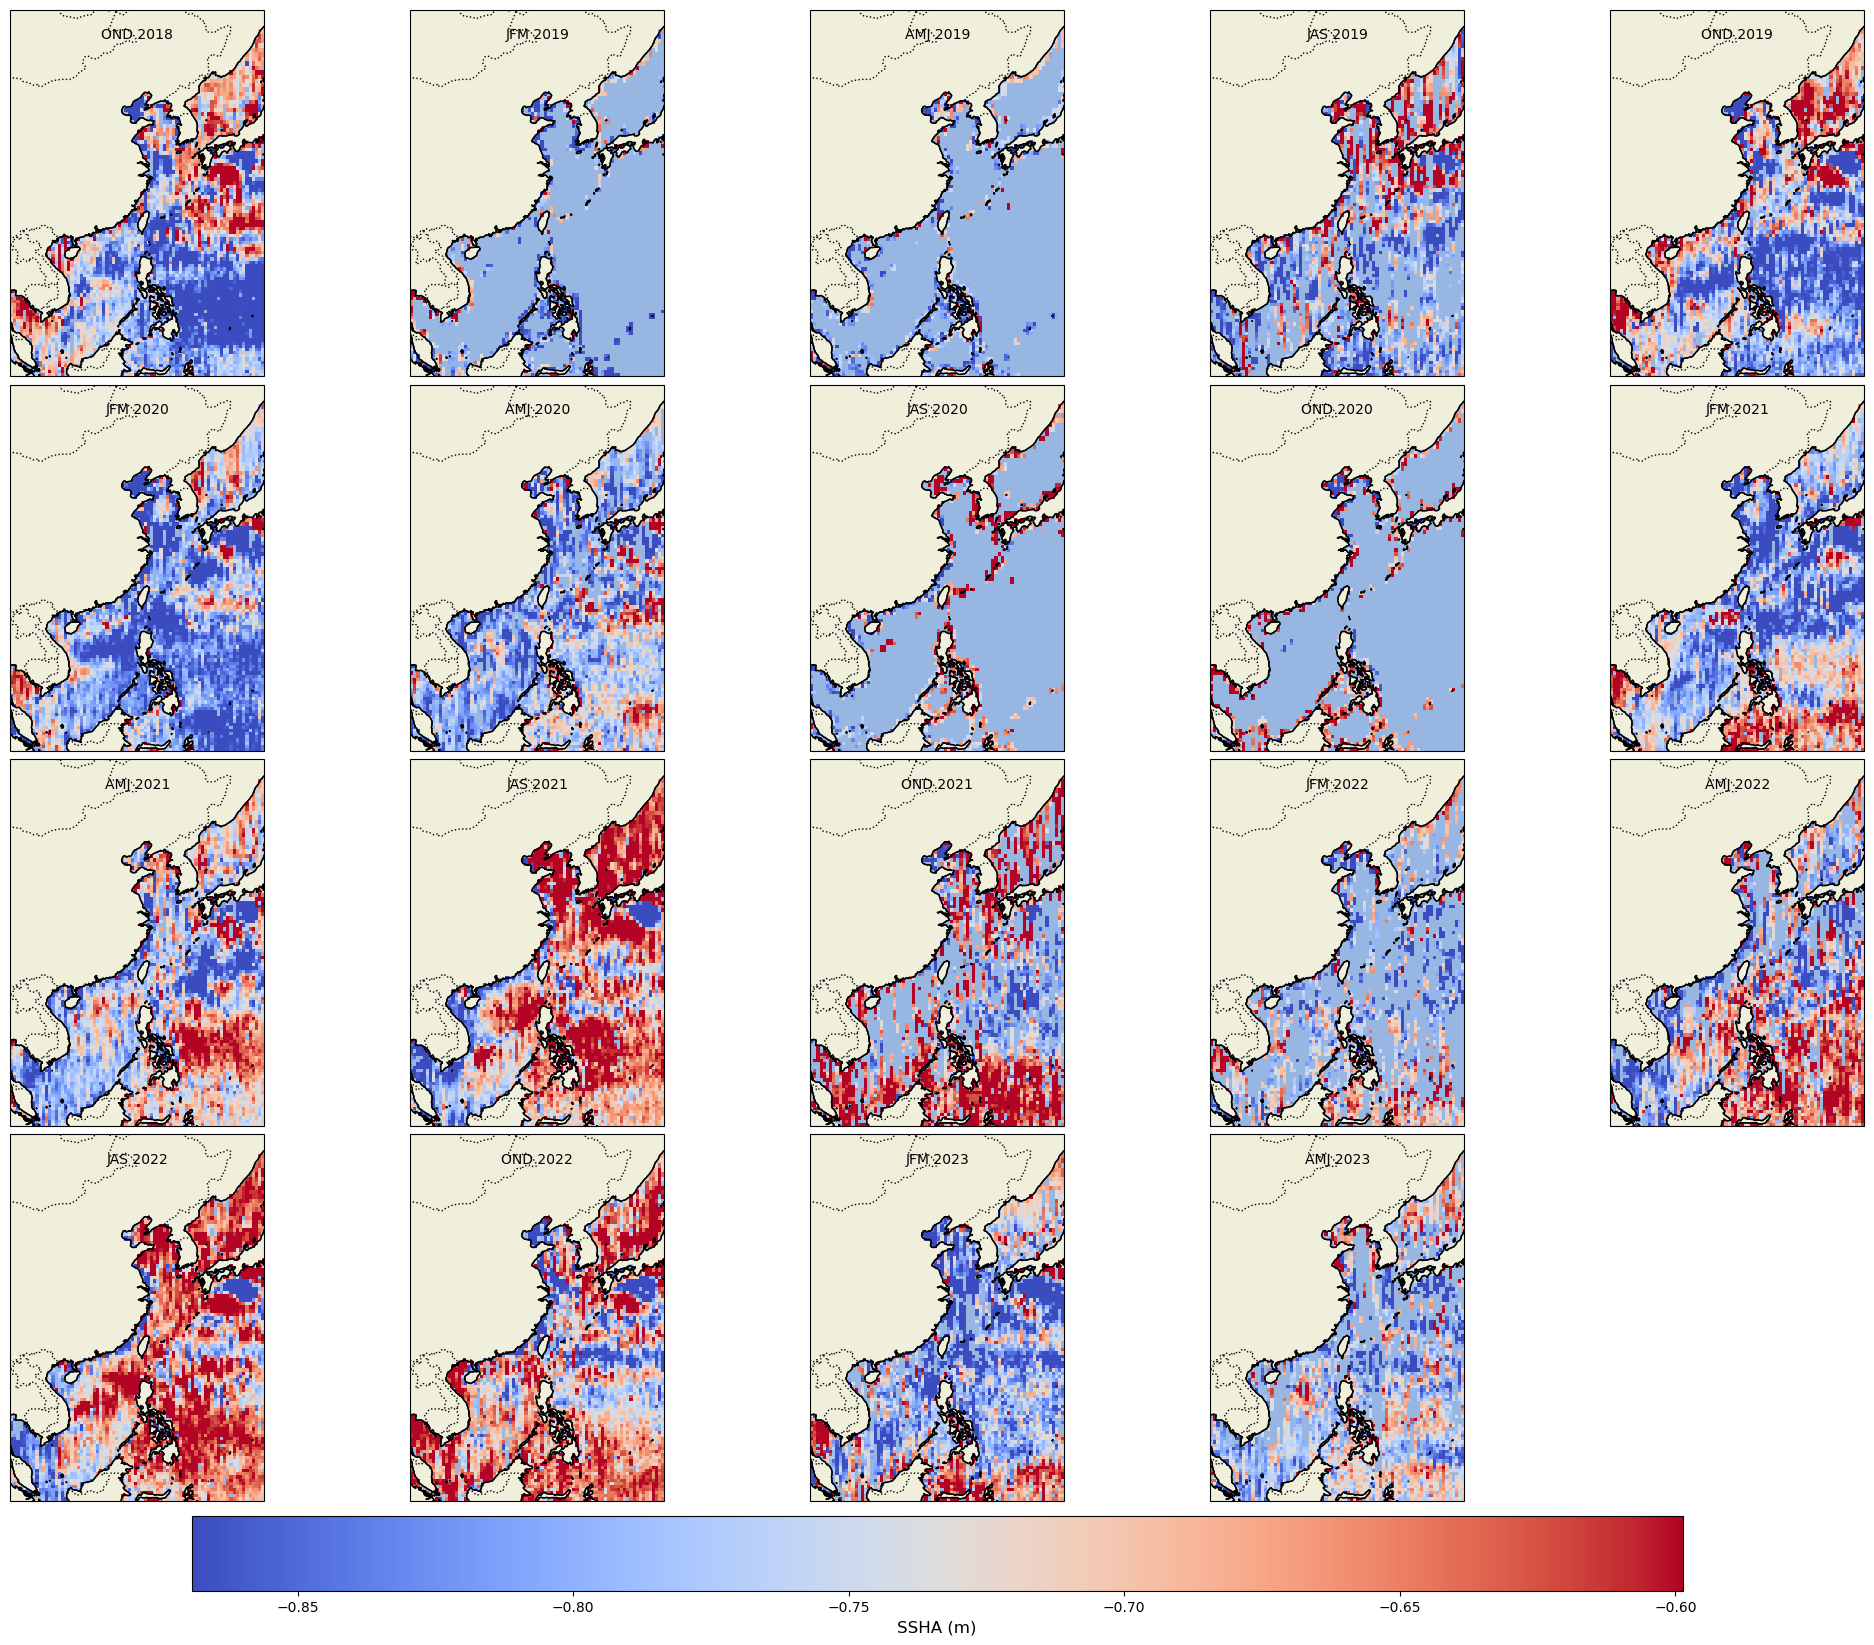

In [27]:
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 20), subplot_kw={'projection': ccrs.Mercator()}, constrained_layout=True)
axs = axs.ravel()
plot_count = 0  
for year in range(2018, 2024):
    for season in ['JFM', 'AMJ', 'JAS', 'OND']:
        # 检查是否是特殊年份的特定季节
        if year in special_years and season not in special_years[year]:
            continue

        ax = axs[plot_count]
        plot_count += 1

        # 筛选特定季节的数据
        mask = (df_gt2r['Date'].dt.year == year) & (df_gt2r['Date'].dt.month.isin(season_months[season]))
        season_df = df_gt2r[mask]

        # 计算SSHA值的平均值
        ssha_grid = interpolate_ssha(season_df, grid_lon, grid_lat, grid_res)
        masked_data = np.ma.masked_where(is_land, ssha_grid)

        # 绘制数据
        img = ax.pcolormesh(grid_lon, grid_lat, masked_data, transform=ccrs.PlateCarree(),
                            cmap='coolwarm', vmin=vmin, vmax=vmax)

        # 添加地图特征
        ax.coastlines()
        ax.add_feature(cfeature.LAND)
        ax.add_feature(cfeature.OCEAN)
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.BORDERS, linestyle=':')

        # 设置标题
        ax.text(0.5, 0.95, f'{season} {year}', transform=ax.transAxes, ha='center', va='top',
                fontsize=10)

# 删除未使用的子图
for ax in axs[plot_count:]:
    fig.delaxes(ax)

# 添加共用的颜色条
cbar = fig.colorbar(img, ax=axs[:plot_count], orientation='horizontal', fraction=0.05, pad=0.01)
cbar.set_label('SSHA (m)', size=12)

plt.savefig(r'D:\BF\Desktop\season_icesat-2_ssha.png', dpi=400)
plt.show()

In [28]:
year = 2020
season_months = [7, 8, 9]
lat_min, lat_max = 15, 30
lon_min, lon_max = 128, 138

In [29]:
filtered_data = df_gt2r[
    (df_gt2r['Date'].dt.year == year) &
    (df_gt2r['Date'].dt.month.isin(season_months)) &
    (df_gt2r['Latitude'] >= lat_min) & (df_gt2r['Latitude'] <= lat_max) &
    (df_gt2r['Longitude'] >= lon_min) & (df_gt2r['Longitude'] <= lon_max)
]

filtered_data

,Unnamed: 0,Longitude,Latitude,SSH,Date,MSS,SSHA
435233,435233,131.672605,26.120960,36.341450,2020-07-01,37.138610,-0.797160
435234,435234,131.668101,26.165821,36.069820,2020-07-01,36.915907,-0.846086
435235,435235,131.660578,26.229248,35.609425,2020-07-01,36.546878,-0.937453
435236,435236,131.652691,26.300538,35.330284,2020-07-01,36.181179,-0.850895
435237,435237,131.648094,26.349930,35.106880,2020-07-01,35.960004,-0.853124
435238,435238,131.641995,26.408178,34.842910,2020-07-01,35.712739,-0.869828
435239,435239,131.634213,26.472560,34.573900,2020-07-01,35.407152,-0.833254
436386,436386,129.208557,27.291666,26.883228,2020-07-14,27.564833,-0.681605
436387,436387,129.201736,27.351868,27.178795,2020-07-14,27.881276,-0.702481
436388,436388,129.188453,27.470619,27.826685,2020-07-14,28.519262,-0.692577
